# Good Seed

## 1. Contenido

* [1 Contenido](#content)
* [2 Introducción](#intro)
* [3 Inicialización](#inic)
    * [3.1 Cargar Librerias](#library)
    * [3.2 Cargar Datos](#datos)
* [4 EDA](#eda) 
    * [4.1 Conclusiones](#eda_end)
* [5 Modelado](#model)
* [6 Prepara el script para ejecutarlo en la plataforma GPU](#script)
    * [6.1 El resultado](#result)
* [7 Conclusiones](#end)

## 2. Introducción

En el presente proyecto procederemos a desarrollar un modelo de machine learning, específicamente una red neuronal, para la cadena de supermercados Good Seed con el objetivo de analizar si es posible que este verifique la edad de las personas para la venta de alcohol a las mismas.

Comenzaremos revisando los datos proporcionados, crearemos funciones y un script para ejecutarlos en una plataforma GPU y finalmente analizaremos los resultados.

## 3. Inicialización

Se procede a cargar las librerías que se utilizaran en el proyecto.

### 3.1. Carga de librerías

In [1]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

import os
import random 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

### 3.2. Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
labels_df = pd.read_csv('/datasets/faces/labels.csv')

## 3. EDA

Comenzamos con la exploración de los datos para sacar una conclusión final.

In [3]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

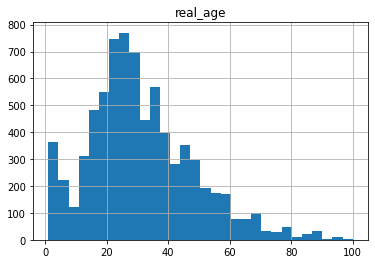

In [4]:
labels_df.hist('real_age', bins=30)

In [5]:
path='/datasets/faces/final_files/'

random_image=[]
for x in range(0,15):
    random_filename = random.choice([
    x for x in os.listdir(path)
    if os.path.isfile(os.path.join(path, x))])
    random_image.append(random_filename)

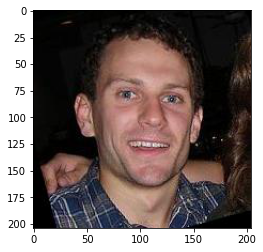

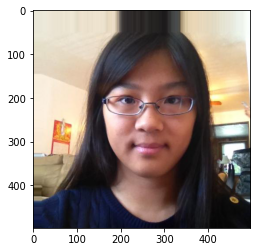

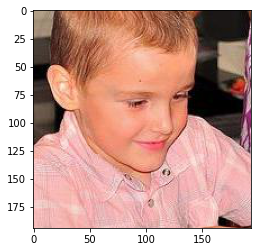

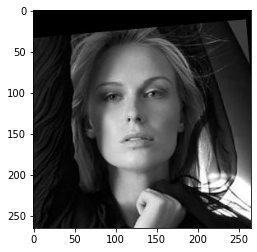

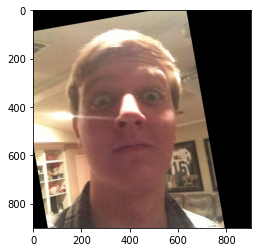

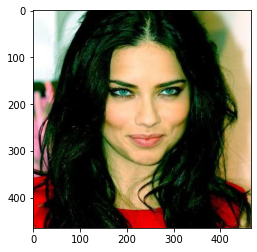

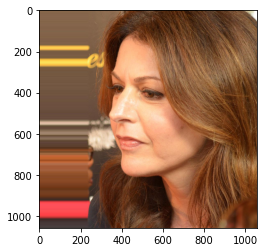

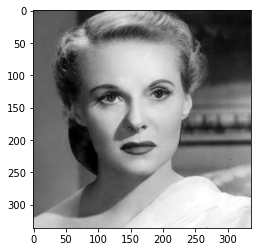

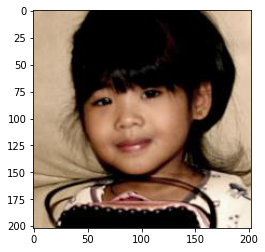

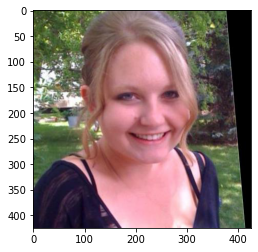

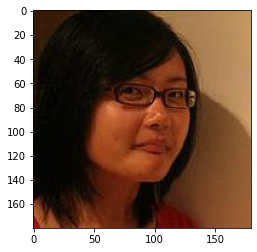

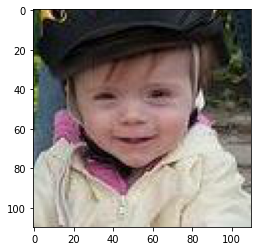

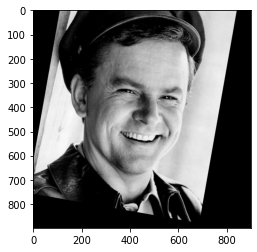

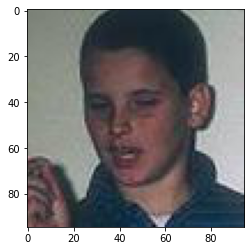

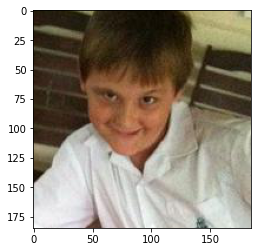

In [6]:
for photo in random_image:
    image = Image.open(f'/datasets/faces/final_files/{photo}')
    plt.imshow(image)
    plt.show()

### Conclusiones

Podemos apreciar que no existen valores nulos entre las etiquetas de los dados, por otra parte, entre las fotos existen personas desde el año hasta los 100 años, acumulándose mayoritariamente la distribución entre los 10 y 40 años, teniendo su peak alrededor de los 20 años. Lo anterior es lógico debido a que el principal objetivo es distinguir si una persona es mayor de edad y la mayor dificultad se encontrara alrededor de los 20 años que es cuando se pasa a la mayoría de edad. 

Finalmente observando un set de 15 fotos al azar podemos apreciar que estas se centran en la cara de las personas, hay fotos en blanco y negro y a color, centradas y un poco rotadas. 

## 4. Modelado

Definiremos las funciones necesarias para entrenar el modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

In [12]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    train_gen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

    return train_gen_flow

In [13]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    test_gen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

    return test_gen_flow

In [14]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False, classes=1000)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu')) 

    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)  
    
    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2) 


    return model

## 5. Preparación el script para ejecutarlo en la plataforma GPU

In [ ]:
init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### 5.1. El resultado

Resultado de la plataforma GPU 

238/238 - 38s - loss: 4.6607 - mae: 4.6629
Test MAE: 4.6629

## 6. Conclusiones

Como podemos apreciar, el error absoluto medio de la muestra de prueba es de alrededor de 4 años y medio, esto podría parecer un valor bajo si consideramos que tenemos un pool de personas de hasta los 100 años, pero para el objetivo del proyecto que es poder diferenciar si una persona es mayor de edad para autorizar la venta de alcohol puede ser un error muy grande para el grupo objetivo que son las personas que quieren comprar alcohol y son menores de edad pero que se encuentran cercanas a cumplir su mayoría de edad.

 Debido a lo anterior es que, aunque el modelo a grandes rasgos funciona de manera correcta, no sería aconsejable su uso con los parámetros que posee en este momento ya que tiene un margen de error suficiente para equivocarse en los casos más críticos para los que quiere ser utilizado, que son adolescentes que quieren comprar alcohol y aun no cumplen la mayoría de edad.